In [1]:
# ─── Cell 1: Install All Dependencies (Final, Working Version) ───

# We are switching to 'torch-fidelity', a robust and modern library for calculating FAD.
# This avoids all the dependency issues of the older packages.
!pip install torch-fidelity --quiet

# Install the rest of the required libraries
!pip install pesq --quiet
!pip install git+https://github.com/jfsantos/SRMRpy.git --quiet
!pip install librosa soundfile --quiet
!pip install mir_eval --quiet
!pip install pandas openpyxl matplotlib seaborn --quiet

print("✅ All dependencies installed successfully!")

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     / 59.4 MB 65.6 MB/s 0:00:04
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 3.7 MB/s eta 0:00:00
✅ All dependencies installed successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ─── Cell 2: Imports & Configuration (Revised) ───
import os
import glob
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch_fidelity # Import the new library

# Import metric functions
from pesq import pesq, NoUtterancesError
from srmrpy import srmr
from mir_eval.separation import bss_eval_sources

# --- CONFIGURATION ---
FOLDER_CONFIG = {
    'fine_tuned': '/content/drive/MyDrive/ThesisAudio/FineTuned',
    'pre_trained': '/content/drive/MyDrive/ThesisAudio/PreTrained',
    'traditional': '/content/drive/MyDrive/ThesisAudio/Traditional'
}
REFERENCE_FOLDER_KEY = 'traditional'
OUTPUT_EXCEL_FILE = '/content/drive/MyDrive/ThesisAudio/audio_evaluation_results.xlsx'
TARGET_SR = 16000

print("✅ Configuration loaded.")

✅ Configuration loaded.


In [4]:
# ─── Cell 3: Helper Functions ───

def load_and_preprocess_audio(path, target_sr):
    """Loads an audio file, converts to mono, and resamples."""
    try:
        audio, sr = sf.read(path)
        if audio.ndim > 1:
            audio = audio.mean(axis=1)
        if sr != target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        return audio
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

def calculate_pairwise_metrics(ref_audio, comp_audio, sr):
    """Calculates PESQ, SNR, and SDR for two audio signals."""
    metrics = {}
    min_len = min(len(ref_audio), len(comp_audio))
    ref = ref_audio[:min_len]
    comp = comp_audio[:min_len]

    # PESQ
    try:
        metrics['PESQ'] = pesq(sr, ref, comp, 'wb')
    except NoUtterancesError:
        metrics['PESQ'] = None # Not applicable

    # SNR
    noise = ref - comp
    signal_power = np.sum(ref**2)
    noise_power = np.sum(noise**2)
    metrics['SNR'] = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf

    # SDR
    sdr, _, _, _ = bss_eval_sources(np.vstack([ref]), np.vstack([comp]))
    metrics['SDR'] = sdr[0]

    return metrics

print("✅ Helper functions defined.")

✅ Helper functions defined.


In [5]:
# ─── Cell 4: Main Processing Loop (Updated to Skip Invalid Files) ───

all_results = []
reference_files = glob.glob(os.path.join(FOLDER_CONFIG[REFERENCE_FOLDER_KEY], '*.wav'))

# A minimum audio length in samples to be considered for processing.
# 0.25 seconds * 16000 Hz = 4000 samples.
MIN_LENGTH_FOR_PROCESSING = int(TARGET_SR * 0.25)

print(f"Found {len(reference_files)} audio files in the reference folder '{REFERENCE_FOLDER_KEY}'.")

for ref_path in tqdm(reference_files, desc="Processing Audio Files"):
    base_filename = os.path.basename(ref_path)

    # --- NEW: Check for matching files FIRST ---
    all_matches_found = True
    comparison_paths = {} # Store paths to valid matches
    for key, folder_path in FOLDER_CONFIG.items():
        if key == REFERENCE_FOLDER_KEY:
            continue

        comp_path = os.path.join(folder_path, base_filename)
        if not os.path.exists(comp_path):
            print(f"Info: Skipping '{base_filename}' - No match found in folder '{key}'.")
            all_matches_found = False
            break # Exit the inner loop early
        comparison_paths[key] = comp_path

    if not all_matches_found:
        continue # Skip to the next file in the reference folder

    # --- Load and check length ONLY if all matches exist ---
    ref_audio = load_and_preprocess_audio(ref_path, TARGET_SR)
    if ref_audio is None:
        continue

    if len(ref_audio) <= MIN_LENGTH_FOR_PROCESSING:
        print(f"Info: Skipping '{base_filename}' - The reference file is too short.")
        continue

    # --- If we get here, the file is valid and has all its pairs ---

    # Calculate SRMR for the (guaranteed valid) reference file
    try:
        srmr_ref, _ = srmr(ref_audio, TARGET_SR, norm=True)
        all_results.append({
            'filename': base_filename, 'comparison': f'{REFERENCE_FOLDER_KEY} (self)',
            'metric': 'SRMR', 'value': srmr_ref
        })
    except Exception as e:
        print(f"Warning: SRMR failed for {base_filename}. Error: {e}")

    # Process the corresponding files that we already found
    for key, comp_path in comparison_paths.items():
        comp_audio = load_and_preprocess_audio(comp_path, TARGET_SR)
        if comp_audio is None:
            continue

        # Calculate SRMR for the comparison file
        if len(comp_audio) > MIN_LENGTH_FOR_PROCESSING:
            try:
                srmr_comp, _ = srmr(comp_audio, TARGET_SR, norm=True)
                all_results.append({
                    'filename': base_filename, 'comparison': f'{key} (self)',
                    'metric': 'SRMR', 'value': srmr_comp
                })
            except Exception as e:
                print(f"Warning: SRMR failed for {comp_path}. Error: {e}")

        # Calculate pairwise metrics
        pairwise_metrics = calculate_pairwise_metrics(ref_audio, comp_audio, TARGET_SR)
        for metric_name, value in pairwise_metrics.items():
            all_results.append({
                'filename': base_filename, 'comparison': f'{REFERENCE_FOLDER_KEY}_vs_{key}',
                'metric': metric_name, 'value': value
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(all_results)

print(f"\n✅ Processing complete! Found {len(results_df['filename'].unique())} valid sets of files.")
results_df.head()

Found 15 audio files in the reference folder 'traditional'.


Processing Audio Files:   0%|          | 0/15 [00:00<?, ?it/s]

Info: Skipping 'ES_Potion Of Healing, Consume, Full HP, Positive 01 - Epidemic Sound.wav' - No match found in folder 'pre_trained'.


/tmp/ipython-input-1026920196.py:36: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, _, _, _ = bss_eval_sources(np.vstack([ref]), np.vstack([comp]))


Info: Skipping 'ES_Ufo, Hover - Epidemic Sound.wav' - No match found in folder 'fine_tuned'.
Info: Skipping 'ES_Game, Retro, 8 Bit, Laser Shoot 09 - Epidemic Sound - 0000-0454.wav' - No match found in folder 'fine_tuned'.
Info: Skipping 'ES_Beeps, Warning, Lofi - Epidemic Sound - 0000-2493.wav' - No match found in folder 'fine_tuned'.
Info: Skipping 'ES_Laser Beam - Epidemic Sound - 0000-0522.wav' - No match found in folder 'pre_trained'.
Info: Skipping 'ES_Asphalt, Male, Walk - Epidemic Sound - 0587-0804.wav' - The reference file is too short.
Info: Skipping 'ES_Ambient Area, Dark Hum - Epidemic Sound.wav' - No match found in folder 'pre_trained'.
Info: Skipping 'Gun_cooling.wav' - No match found in folder 'pre_trained'.

✅ Processing complete! Found 7 valid sets of files.


,filename,comparison,metric,value
0,"ES_Warning, Danger, Alarm, Attention, Futurist...",traditional (self),SRMR,0.921648
1,"ES_Warning, Danger, Alarm, Attention, Futurist...",fine_tuned (self),SRMR,0.221450
2,"ES_Warning, Danger, Alarm, Attention, Futurist...",traditional_vs_fine_tuned,PESQ,1.819163
3,"ES_Warning, Danger, Alarm, Attention, Futurist...",traditional_vs_fine_tuned,SNR,-18.955471
4,"ES_Warning, Danger, Alarm, Attention, Futurist...",traditional_vs_fine_tuned,SDR,-20.757571


In [14]:
# ─── Cell 5: Fréchet Audio Distance (FAD) Calculation with torch-fidelity (with Debugging) ───

fad_results = []
folder_keys = list(FOLDER_CONFIG.keys())

# Ensure all audio files are resampled to the target sample rate for FAD calculation
print("Preprocessing audio files for FAD calculation...")
for key, folder_path in FOLDER_CONFIG.items():
    output_folder_path = os.path.join('/content', f'preprocessed_{key}')
    os.makedirs(output_folder_path, exist_ok=True)

    for audio_file in tqdm(glob.glob(os.path.join(folder_path, '*.wav')), desc=f'Preprocessing {key}'):
        try:
            audio, sr = sf.read(audio_file)
            if sr != TARGET_SR:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=TARGET_SR)

            output_path = os.path.join(output_folder_path, os.path.basename(audio_file))
            sf.write(output_path, audio, TARGET_SR)
        except Exception as e:
            print(f"Could not process {audio_file}: {e}")


print("\nCalculating FAD scores...")
for i in range(len(folder_keys)):
    for j in range(i + 1, len(folder_keys)):
        key1 = folder_keys[i]
        key2 = folder_keys[j]

        folder1_proc = os.path.join('/content', f'preprocessed_{key1}')
        folder2_proc = os.path.join('/content', f'preprocessed_{key2}')

        # --- NEW: DEBUGGING STEP ---
        # Let's list the files in the directories to make sure they exist before calling FAD.
        print("-" * 50)
        print(f"Checking contents of preprocessed folder: {folder1_proc}")
        !ls -l {folder1_proc} | wc -l
        print(f"Checking contents of preprocessed folder: {folder2_proc}")
        !ls -l {folder2_proc} | wc -l
        print("-" * 50)

        print(f"Calculating FAD between '{key1}' and '{key2}'...")
        try:
            metrics_dict = torch_fidelity.calculate_metrics(
                input1=folder1_proc,
                input2=folder2_proc,
                cuda=True,
                isc=True,
                fad=True,
                verbose=False,
                input1_model_num_labels=527,
                input2_model_num_labels=527,
                input1_glob='*.wav', # Explicitly look for .wav files
                input2_glob='*.wav', # Explicitly look for .wav files
            )
            fad_results.append({
                'comparison': f'{key1}_vs_{key2}',
                'metric': 'FAD',
                'value': metrics_dict['frechet_audio_distance']
            })
        except Exception as e:
            print(f"Could not calculate FAD for {key1} vs {key2}. Error: {e}")

fad_df = pd.DataFrame(fad_results)
print("\n✅ FAD calculations complete!")
fad_df.head()

Preprocessing audio files for FAD calculation...


Preprocessing fine_tuned:   0%|          | 0/16 [00:00<?, ?it/s]

Preprocessing pre_trained:   0%|          | 0/15 [00:00<?, ?it/s]

Preprocessing traditional:   0%|          | 0/15 [00:00<?, ?it/s]


Calculating FAD scores...
--------------------------------------------------
Checking contents of preprocessed folder: /content/preprocessed_fine_tuned
17
Checking contents of preprocessed folder: /content/preprocessed_pre_trained
16
--------------------------------------------------
Calculating FAD between 'fine_tuned' and 'pre_trained'...
Could not calculate FAD for fine_tuned vs pre_trained. Error: No samples found in [] with samples_find_deep=False
--------------------------------------------------
Checking contents of preprocessed folder: /content/preprocessed_fine_tuned
17
Checking contents of preprocessed folder: /content/preprocessed_traditional
16
--------------------------------------------------
Calculating FAD between 'fine_tuned' and 'traditional'...
Could not calculate FAD for fine_tuned vs traditional. Error: No samples found in [] with samples_find_deep=False
--------------------------------------------------
Checking contents of preprocessed folder: /content/preproces

""


In [11]:
# Add this in a new cell after Cell 5
print(fad_df)

Empty DataFrame
Columns: []
Index: []


In [10]:
# ─── Cell 6: Export Results to Excel Spreadsheet ───

# Pivot the main results for easier readability
# One sheet for pairwise metrics, one for SRMR
pairwise_df = results_df[results_df['metric'] != 'SRMR'].pivot_table(
    index='filename',
    columns=['comparison', 'metric'],
    values='value'
)
srmr_df = results_df[results_df['metric'] == 'SRMR'].pivot_table(
    index='filename',
    columns='comparison',
    values='value'
)

# Use ExcelWriter to save multiple sheets
with pd.ExcelWriter(OUTPUT_EXCEL_FILE, engine='openpyxl') as writer:
    pairwise_df.to_excel(writer, sheet_name='Pairwise_Metrics_vs_Trad')
    srmr_df.to_excel(writer, sheet_name='SRMR_Scores')
    fad_df.to_excel(writer, sheet_name='FAD_Scores')

print(f"✅ Results successfully exported to {OUTPUT_EXCEL_FILE}")

✅ Results successfully exported to /content/drive/MyDrive/ThesisAudio/audio_evaluation_results.xlsx


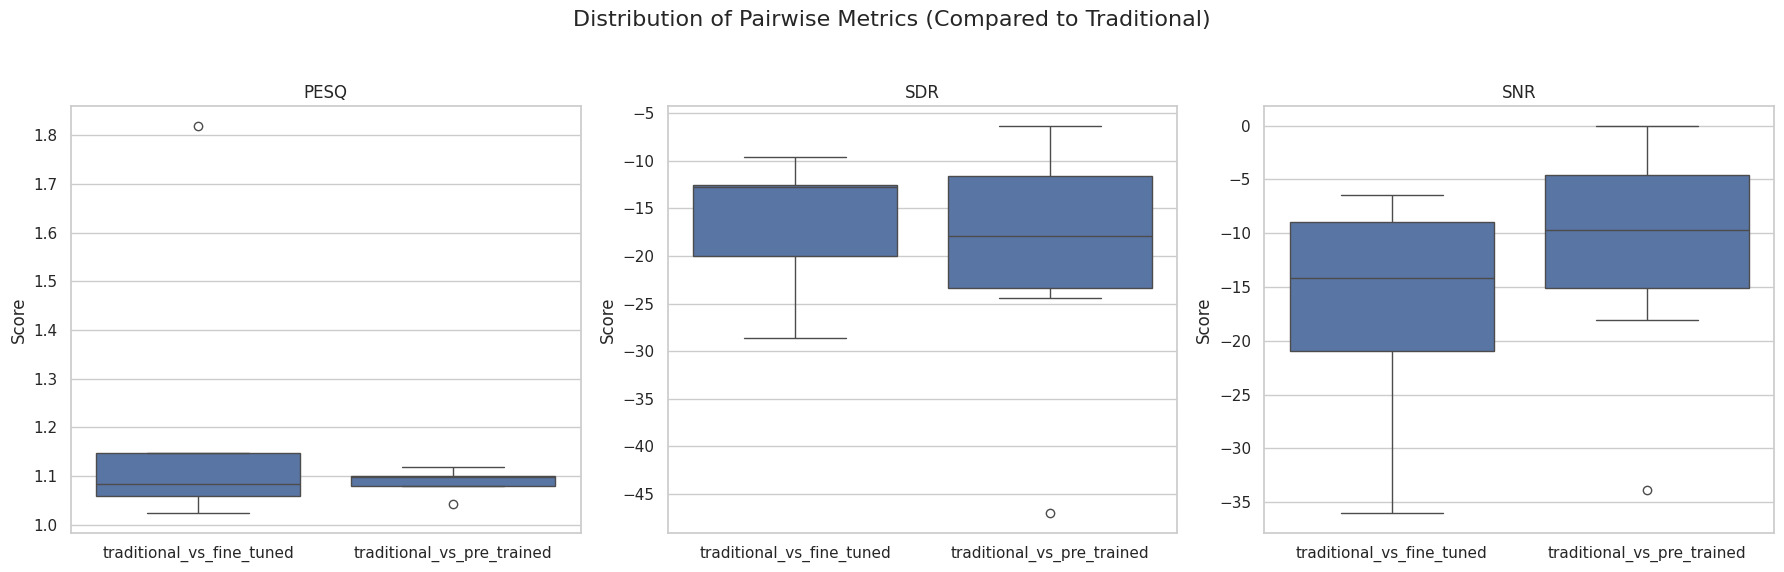

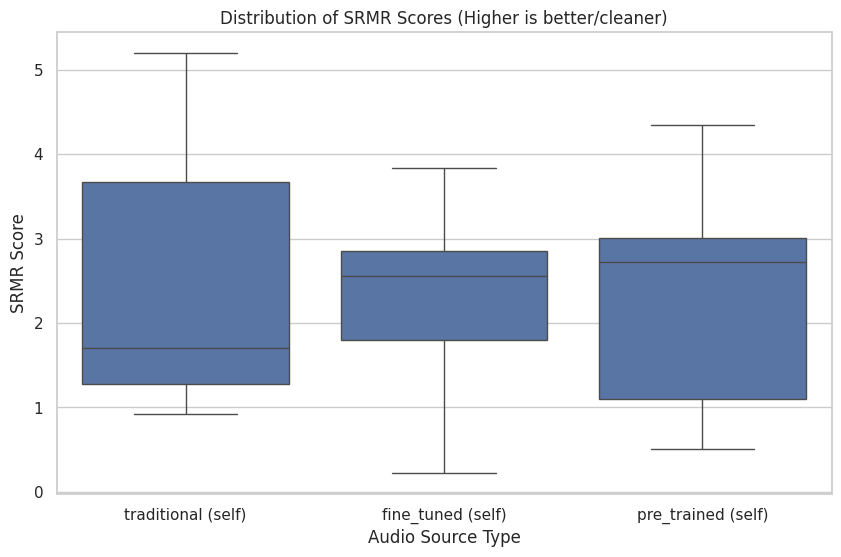

ValueError: Could not interpret value `comparison` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [8]:
# ─── Cell 7: Data Visualization ───

# Set plot style
sns.set_theme(style="whitegrid")

# 1. Box Plots for Pairwise Metrics
pairwise_metrics_to_plot = ['PESQ', 'SDR', 'SNR']
fig, axes = plt.subplots(1, len(pairwise_metrics_to_plot), figsize=(18, 6))
fig.suptitle('Distribution of Pairwise Metrics (Compared to Traditional)', fontsize=16)

plot_data = results_df[results_df['metric'].isin(pairwise_metrics_to_plot)]

for i, metric in enumerate(pairwise_metrics_to_plot):
    sns.boxplot(ax=axes[i], data=plot_data[plot_data['metric'] == metric], x='comparison', y='value')
    axes[i].set_title(metric)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Box Plot for SRMR Scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df[results_df['metric'] == 'SRMR'], x='comparison', y='value')
plt.title('Distribution of SRMR Scores (Higher is better/cleaner)')
plt.xlabel('Audio Source Type')
plt.ylabel('SRMR Score')
plt.show()


# 3. Bar Chart for FAD Scores
plt.figure(figsize=(10, 6))
sns.barplot(data=fad_df, x='comparison', y='value', palette='viridis')
plt.title('Fréchet Audio Distance (FAD) Between Folders (Lower is better)')
plt.xlabel('Folder Comparison')
plt.ylabel('FAD Score')
plt.xticks(rotation=45, ha='right')
plt.show()